## Introduction to Parameter Estimation or Inverse Problems

In [1]:
using OrdinaryDiffEq, ParameterizedFunctions,Plots, RecursiveArrayTools

ArgumentError: Module Hiccup not found in current path.
Run `Pkg.add("Hiccup")` to install the Hiccup package.


Parameter Estimation in one line can be described as obtaining parameters for mathematical models by data fitting. 

Let's discuss what that implies specifically in context of our interest here, which are Differential Equation Models. The general structure of a differential equation model can be described as 
$$\mathbf{\dot{x}}(\textit{t}) = f(\textbf{x}(\textit{t}), \textbf{u}, \textit{t} \hspace{0.1cm}|\hspace{0.1cm} \theta)$$

Here, $t$ denotes the independent variable, usually time, $\theta$ is a p-dimensional vector of unknown parameters, $x = x(t,\theta)$ is an n-dimensional state variable vector depending on $t$ and $\theta$, and thus the function $f(t,x,\theta)$ maps $R\times R^n\times R^p$ into $R^n$.

We are interested in obtaining this vector $\theta$ with the help of data describing the trajectory of the solution of our equation with some noise, to give you a more intuitive understanding of how different parameter values affect the solutions let's take a look at FitzHugh-Nagumo model which is often used as a generic model for excitable media such as a neuron.

In [7]:
fitz = @ode_def_nohes FitzhughNagumo begin
  dv = v - v^3/3 -w + l
  dw = τinv*(v +  a - b*w)
end a b τinv l
u0 = [1.0;1.0]
tspan = (0.0,100.0)
p = [0.7,0.8,1/12.5,0.5]
prob = ODEProblem(fitz,u0,tspan,p)


DiffEqBase.ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: [1.0, 1.0]

#### With $\theta$ as [0.7,0.8,1/12.5,0.5]

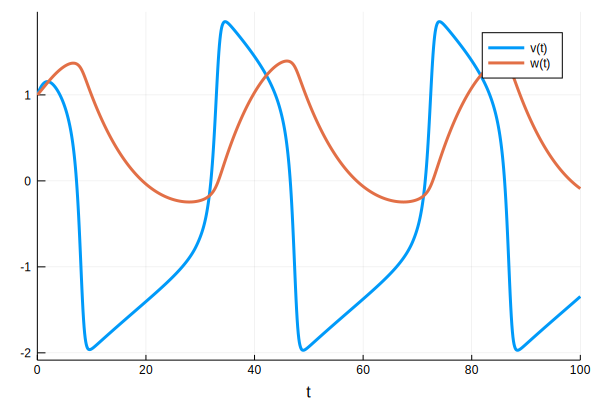

In [8]:
sol = solve(prob,Tsit5())
plot(sol)

#### With $\theta$ as [2.0,2.0,1/15,1.0]

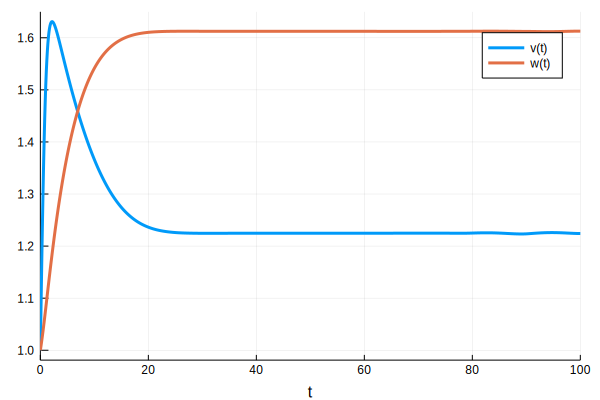

In [4]:
p = [2.0,2.0,1/15,1.0]
prob = ODEProblem(fitz,u0,tspan,p)
sol = solve(prob,Tsit5())
plot(sol)

Now let's suppose you know that the model that you want to use is FitzHugh-Nagumo, you have some data points with some noise as depicted below.

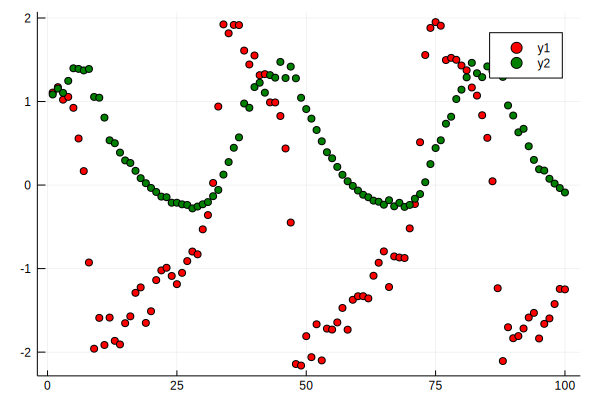

In [9]:
t = collect(linspace(1,100,100))
rand_sol = VectorOfArray([(sol(t[i]) + .1randn(2).*sol(t[i])) for i in 1:length(t)])
scatter(t,rand_sol[1,:],color=:red)
scatter!(t,rand_sol[2,:],color=:green)

So our problem now becomes pretty much this, what values of $\theta$ can we get such that the model adequately describes this exact phenomena given that we are sure that the model is correct, this part of the scientific modelling pipeline is parameter estimation.

Now let's look at this problem from a Bayesian Perspective.

Quick refresher, Bayes' Theorem 

$$ P(A \mid B) = \frac{P(B \mid A) \, P(A)}{P(B)} $$


This provides us with a convenient way to frame our problem, let's take the event of getting our noisy data points as B and the event of getting a specific $\theta$ as A. So $P(A \mid B)$ is the *Posterior* and it represents the probability of our current set of parameters, $\theta$ conditioned on our noisy data. $P(B \mid A)$ is known as the *Likelihood*, it represents the probability of our data conditioned on our current $\theta$, $P(A)$ is the *Prior* probability of the current $\theta$ and $P(B)$ is the probability of observing our data, which is going to be constant irrespective of $\theta$.

As is the trend in such problems, now we aim to maximize the $P(A \mid B)$ (actually the $log$ of it) which would give us the best set of parameters $\theta$ thst describe our data.

### What we do in DiffEqBayes. 

Let's go through an example problem, the one mentioned above, the FitzHugh-Nagumo model. We will try to predict the parameters using the random data we created.

DiffEqBayes supports 4 backends. Turing.jl, you might have attended the wonderful talk by Hong Ge regarding it, Stan.jl which provides an interface to the Stan probabilistic programming language, DynamicHMC.jl, these provide some of the popular MCMC methods and NUTS-HMC algorithm for sampling from the posterior. There is also the option to use Approximate Bayesian Computation for sampling with the ApproxBayes.jl backend.

Basically different backends with each one having one or multiple ways to sample from the posterior distribution.

With the tools provided by these backends you can analyse the results of the sampling and get more statistical knowledge regarding the distribution of the Parameters. We are mainly interested in the means and the variances, as the means provide an unbiased estimator of the expectation and provide us with a point estimate we are interested in as our parameter value.

Let's run through a benchmark problem as an example of usage of DiffEqBayes and the related packages that act as bakends and provide some analysis tools.